# Ensemble Machine learning

In this notebook, we try to improve predictions through ensemble machine learning's method. The combination of uncorrelated models bring a less biased estimations which increase the metrics. Increasing the number of models should bring better results for future application.

    * Problem transformation :
        Binary relevance
    * Classifiers :
        Ridge Regression 
            AUC : 
            AUC mass : 1.000 - AUC source : 0.969
        Random forest
            AUC : 
            AUC mass : 1.000 - AUC source : 0.971
        Naive Bayes
            AUC : 
            AUC mass : 0.994 - AUC source : 0.965

## 0. Import


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn


from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet
from helpers.plot.plot_roc import colorline

import warnings
warnings.filterwarnings('ignore')


from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold, cross_val_predict

## 1. Predictions Generation

In [5]:
ratio = 0.75
percent = np.array([0.005, 0.015, 0.005])
size = 10000

batch_size = 64

if False:
    res = Residual()
    res.build(size, ratio = ratio, per_error = percent)

In [6]:
str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])
data_set = CombineDataset(metadata,'ID','class',final_array)

_, data_test = train_test_split(data_set,train_size=0.85,random_state=42)
loader_test = DataLoader(data_test, batch_size = batch_size, 
                         num_workers = 8, drop_last=True, pin_memory = True)

In [7]:
models_name = ['BasicCNN', 'AlexNet', 'VGG11', 'GoogleNet', 'ResNet18', 'DenseNet121', 'SqueezeNet']


mass_pred = pd.DataFrame(); 
source_pred = pd.DataFrame(); 
for model_i in models_name:
    netbasic = NeuralNet(model_i, 'SGD/momentum')
    netbasic.load_checkpoint('_optimal')

    with torch.no_grad():
        predictions = []; targets = []
        for data in loader_test:
            images, _, labels = data
            if model_i is not 'BasicCNN':
                m = nn.ZeroPad2d(80)
                images = m(images)
            
            if model_i is not 'GoogleNet':
                outputs = netbasic.net(images)
            else :
                outputs,_,_ = netbasic.net(images)


            predictions.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    mass_pred[model_i] = np.asarray(predictions)[:,0].tolist()
    source_pred[model_i] = np.asarray(predictions)[:,1].tolist()

mass_pred['label'] = np.asarray(targets)[:,0].tolist()
source_pred['label'] = np.asarray(targets)[:,1].tolist()

Xsource_train, Xsource_test, ysource_train, ysource_test = train_test_split(source_pred[models_name], source_pred['label'],train_size=0.85,random_state=42)
Xmass_train, Xmass_test, ymass_train, ymass_test = train_test_split(mass_pred[models_name], mass_pred['label'],train_size=0.85,random_state=42)

In [8]:
Xsource_train, Xsource_test, ysource_train, ysource_test = train_test_split(source_pred[models_name], source_pred['label'],train_size=0.85,random_state=42)
Xmass_train, Xmass_test, ymass_train, ymass_test = train_test_split(mass_pred[models_name], mass_pred['label'],train_size=0.85,random_state=42)

## 1. Source Error

### 1.1 Parameters selection

##### Random Forest


In [9]:
max = 0; max_depth_source = 1; max_estimator_source = 100; max_features_source = 2;
k = 0; random_state = 10
cv = KFold(n_splits=10, random_state = random_state)
while k < 10:
    for i in range(1,30):
        clf = RandomForestClassifier(max_depth=i, n_estimators=max_estimator_source, max_features=max_features_source, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf, source_pred[models_name], source_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_depth_source =  i; 
    
    for i in range(1,150):
        clf = RandomForestClassifier(max_depth=max_depth_source, n_estimators=i, max_features=max_features_source, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf, source_pred[models_name], source_pred['label'],  scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_estimator_source =  i; 

    for i in range(1,10):
        clf = RandomForestClassifier(max_depth=max_depth_source, n_estimators=max_estimator_source, max_features=i, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf, source_pred[models_name], source_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_features_source =  i; 
    k += 1


print('Optimal max depth : ', max_depth_source, '- Optimal number of estimators :', max_estimator_source, ' - Optimal maximum number of features: ', max_features_source)
print('Accuracy', max)

Optimal max depth :  13 - Optimal number of estimators : 86  - Optimal maximum number of features:  2
Accuracy 0.9705498149328602


##### Ridge Regression


In [10]:
# Cross validation on a ridge regression with ten fold
cv_ridge = KFold(n_splits=10, random_state = random_state)
gs_ridge_source = RidgeCV(alphas = [10**i for i in np.logspace(-2,1, 500)], fit_intercept = False, scoring = 'roc_auc', cv = cv_ridge)

# Fit the ridge regression
gs_ridge_source.fit(source_pred[models_name], source_pred['label'])

print("Best lambda :", gs_ridge_source.alpha_, "\n")
print("Optimal weight:", gs_ridge_source.coef_, "\n")

Best lambda : 1.023292992280754 

Optimal weight: [ 0.65970353 -0.15701002  0.19240315  0.2005156  -0.02273908  0.1016169
  0.03736631] 



### 1.2 Final results

    Ridge : 
        * Without Rounding - AUCROC : 0.969
        * With Rounding - AUCROC : 0.909
    RandomForest :
        * Without Rounding - AUCROC : 0.971
        * With Rounding - AUCROC : 0.907
    Naive Bayes :
        * Without Rounding - AUCROC : 0.965
        * With Rounding - AUCROC : 0.903


In [11]:
classifiers_source = { 'Ridge':Ridge(alpha=gs_ridge_source.alpha_,  fit_intercept = False),
               'RandomForest':RandomForestClassifier(max_depth=max_depth_source, n_estimators=max_estimator_source, max_features=max_features_source, random_state=random_state),
               'GaussianNB': GaussianNB(),
               }
source_final = pd.DataFrame()
cv = KFold(n_splits=10, random_state = random_state)


for key in classifiers_source:
    classifier = classifiers_source[key]
    # evaluate model
    y_pred = cross_val_predict(classifier, source_pred[models_name], source_pred['label'], cv=cv, n_jobs=-1)
    # predict
    AUC = roc_auc_score(source_pred['label'], np.round(y_pred))
    classifiers_source[key].fit(Xsource_train, ysource_train)
    source_final[key] = classifiers_source[key].predict(Xsource_test)

    print(('With rounding - ' +key + ': {:.3f}').format(AUC))
source_final['label'] = ysource_test.to_list()
source_final = source_final.set_index(ysource_test.index)


for key in classifiers_source:
    classifier = classifiers_source[key]
    # evaluate model
    scores = cross_val_score(classifier,source_pred[models_name], source_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
    # predict
    AUC = np.mean(scores)
    classifiers_source[key].fit(Xsource_train, ysource_train)
    source_final[key] = classifiers_source[key].predict(Xsource_test)
    if key != 'Ridge':
        source_final[key] = classifiers_source[key].predict_proba(Xsource_test)[:,1]

    print(('Without rounding - ' +key + ': {:.3f}').format(AUC))
source_final['label'] = ysource_test.to_list()
source_final = source_final.set_index(ysource_test.index)

With rounding - Ridge: 0.909
With rounding - RandomForest: 0.907
With rounding - GaussianNB: 0.903
Without rounding - Ridge: 0.969
Without rounding - RandomForest: 0.971
Without rounding - GaussianNB: 0.965


## 2. Mass error

### 2.1 Parameters selection

##### Random Forest


In [12]:
max = 0; max_depth_mass = 1; max_estimator_mass = 100; max_features_mass = 2;
k = 0
cv = KFold(n_splits=10, random_state = random_state)
while k < 10:
    for i in range(1,30):
        clf = RandomForestClassifier(max_depth=i, n_estimators=max_estimator_mass, max_features=max_features_mass, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf,mass_pred[models_name], mass_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_depth_mass =  i; 
    
    for i in range(1,150):
        clf = RandomForestClassifier(max_depth=max_depth_mass, n_estimators=i, max_features=max_features_mass, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf,mass_pred[models_name], mass_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_estimator_mass =  i; 

    for i in range(1,10):
        clf = RandomForestClassifier(max_depth=max_depth_mass, n_estimators=max_estimator_mass, max_features=i, random_state=random_state)
        # Perform 7-fold cross validation 
        scores = cross_val_score(clf,mass_pred[models_name], mass_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
        if max < np.mean(scores):
            max =  np.mean(scores); 
            max_features_mass =  i; 
    k += 1


print('Optimal max depth : ', max_depth_mass, '- Optimal number of estimators :', max_estimator_mass, ' - Optimal maximum number of features: ', max_features_mass)
print('Accuracy', max)

Optimal max depth :  5 - Optimal number of estimators : 38  - Optimal maximum number of features:  2
Accuracy 0.9996110550599381


##### Ridge Regression


In [13]:
# Cross validation on a ridge regression with ten fold
cv_ridge = KFold(n_splits=10, random_state = random_state)
gs_ridge_mass = RidgeCV(alphas = [10**i for i in np.logspace(-2,1, 500)], fit_intercept = False, scoring = 'roc_auc', cv = cv_ridge)

# Fit the ridge regression
gs_ridge_mass.fit(mass_pred[models_name], mass_pred['label'])

print("Best lambda :", gs_ridge_mass.alpha_, "\n")
print("Optimal weight:", gs_ridge_mass.coef_, "\n")

Best lambda : 151.7430902362539 

Optimal weight: [0.16188094 0.14150419 0.15567498 0.16147971 0.14186557 0.15340873
 0.06194918] 



### 1.2 Final results
    Ridge :  
        * Without Rounding - AUCROC : 1.000
        * With Rounding - AUCROC : 0.990
    RandomForest :
        * Without Rounding - AUCROC : 1.000
        * With Rounding - AUCROC : 0.990
    Naive Bayes :
        * Without Rounding - AUCROC : 0.994
        * With Rounding - AUCROC : 0.989


In [14]:
classifiers_mass = { 'Ridge':Ridge(alpha=gs_ridge_mass.alpha_,  fit_intercept = False),
               'RandomForest':RandomForestClassifier(max_depth=max_depth_mass, n_estimators=max_estimator_mass, max_features=max_features_mass, random_state=random_state),
               'GaussianNB': GaussianNB(),
               }

mass_final = pd.DataFrame()
cv = KFold(n_splits=10, random_state = random_state)

for key in classifiers_mass:
    classifier = classifiers_mass[key]
    # evaluate model
    y_pred = cross_val_predict(classifier,mass_pred[models_name], mass_pred['label'], cv=cv, n_jobs=-1)
    # predict
    AUC = roc_auc_score( mass_pred['label'], np.round(y_pred))

    classifiers_mass[key].fit(Xmass_train, ymass_train)
    mass_final[key] = classifiers_mass[key].predict(Xmass_test)
    print(('With rounding - ' +key + ': {:.3f}').format(AUC))

mass_final['label'] = ymass_test.to_list()
mass_final = mass_final.set_index(ymass_test.index)

for key in classifiers_mass:
    classifier = classifiers_mass[key]
    # evaluate model
    scores = cross_val_score(classifier, mass_pred[models_name], mass_pred['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
    # predict
    AUC = np.mean(scores)

    classifiers_mass[key].fit( Xmass_train, ymass_train)
    mass_final[key] = classifiers_mass[key].predict(Xmass_test)
    if key != 'Ridge':
        mass_final[key] = classifiers_mass[key].predict_proba(Xmass_test)[:,1]
    print(('Without rounding - ' +key + ': {:.3f}').format(AUC))

mass_final['label'] = ymass_test.to_list()
mass_final = mass_final.set_index(ymass_test.index)

With rounding - Ridge: 0.990
With rounding - RandomForest: 0.990
With rounding - GaussianNB: 0.989
Without rounding - Ridge: 1.000
Without rounding - RandomForest: 1.000
Without rounding - GaussianNB: 0.994


## 2. AUROC Curve
In this section, we plot the ROC curve of each model to see their performance.
### Ridge

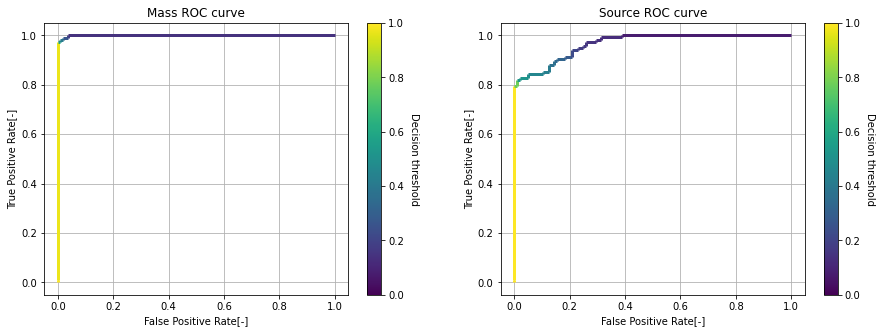

Without Rounding - ROC mass : 0.999 - ROC source : 0.967
With Rounding - ROC mass : 0.986 - ROC source : 0.890


In [15]:
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(mass_final['label'], mass_final['Ridge'])
lr_fpr, lr_tpr, lr_thres = roc_curve(source_final['label'], source_final['Ridge'])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/blending/Ridge.png")
# show the plot
plt.show()

print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], mass_final['Ridge']), 
                                                                       roc_auc_score(source_final['label'], source_final['Ridge'])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], np.round(mass_final['Ridge'])), 
                                                                       roc_auc_score(source_final['label'], np.round(source_final['Ridge']))))


### Random Forest

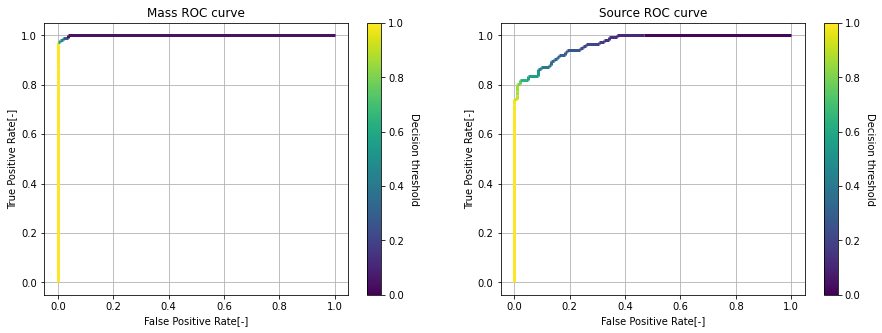

Without Rounding - ROC mass : 0.999 - ROC source : 0.967
With Rounding - ROC mass : 0.982 - ROC source : 0.875


In [16]:
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(mass_final['label'], mass_final['RandomForest'])
lr_fpr, lr_tpr, lr_thres = roc_curve(source_final['label'], source_final['RandomForest'])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/blending/RandomForest.png")
# show the plot
plt.show()

print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], mass_final['RandomForest']), 
                                                                       roc_auc_score(source_final['label'], source_final['RandomForest'])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], np.round(mass_final['RandomForest'])), 
                                                                       roc_auc_score(source_final['label'], np.round(source_final['RandomForest']))))


### Naive Bayes

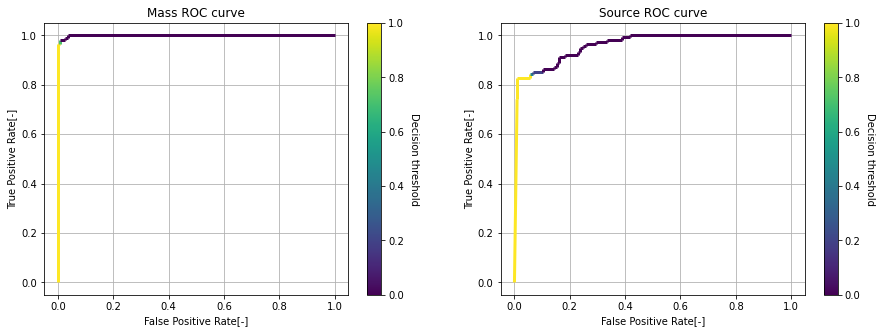

Without Rounding - ROC mass : 0.999 - ROC source : 0.961
With Rounding - ROC mass : 0.977 - ROC source : 0.890


In [17]:
# calculate roc curves
ns_fpr, ns_tpr, ns_thres = roc_curve(mass_final['label'], mass_final['GaussianNB'])
lr_fpr, lr_tpr, lr_thres = roc_curve(source_final['label'], source_final['GaussianNB'])
# plot the roc curve for the model

plt.figure(figsize=(15,5))
plt.subplot(121)
lc = colorline(ns_fpr, ns_tpr, ns_thres, cmap=plt.get_cmap('viridis'))
plt.title('Mass ROC curve')
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()

plt.subplot(122)
lc = colorline(lr_fpr, lr_tpr,  lr_thres, cmap=plt.get_cmap('viridis'))
cbar = plt.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decision threshold', rotation=270)
plt.title('Source ROC curve')
plt.xlabel('False Positive Rate[-]')
plt.ylabel('True Positive Rate[-]')
plt.grid()
plt.savefig("figures/blending/GaussianNB.png")
# show the plot
plt.show()
print('Without Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], mass_final['GaussianNB']), 
                                                                       roc_auc_score(source_final['label'], source_final['GaussianNB'])))
print('With Rounding - ROC mass : {:.3f} - ROC source : {:.3f}'.format(roc_auc_score(mass_final['label'], np.round(mass_final['GaussianNB'])), 
                                                                       roc_auc_score(source_final['label'], np.round(source_final['GaussianNB']))))

## 3. Confusion matrix
Confusion matrix are used in order to understand which class is misclassified and which class isn't. In our case we consider that a combination of each label correspond to a class.

In [24]:
for key in classifiers_mass:
    classifier = classifiers_mass[key]
    # evaluate model
    y_pred = cross_val_predict(classifier,mass_pred[models_name], mass_pred['label'], cv=cv, n_jobs=-1)
    # predict
    AUC = roc_auc_score( mass_pred['label'], np.round(y_pred))

    classifiers_mass[key].fit(Xmass_train, ymass_train)
    mass_final[key] = classifiers_mass[key].predict(Xmass_test)

mass_final['label'] = ymass_test.to_list()
mass_final = mass_final.set_index(ymass_test.index)

for key in classifiers_source:
    classifier = classifiers_source[key]
    # evaluate model
    y_pred = cross_val_predict(classifier, source_pred[models_name], source_pred['label'], cv=cv, n_jobs=-1)
    # predict
    AUC = roc_auc_score(source_pred['label'], np.round(y_pred))
    classifiers_source[key].fit(Xsource_train, ysource_train)
    source_final[key] = classifiers_source[key].predict(Xsource_test)

source_final['label'] = ysource_test.to_list()
source_final = source_final.set_index(ysource_test.index)


list_model = ['RandomForest', 'GaussianNB', 'Ridge', 'label']

final_pred = pd.DataFrame()
for key in list_model:
    _pred = pd.DataFrame()
    _pred['mass'] = np.round(mass_final[key]).to_list()
    _pred['source'] =  np.round(source_final[key]).to_list()

    labels = []
    for label_i in _pred.to_numpy():
        if np.array_equal(label_i, np.array([0, 0])):
            labels.append(0)
        elif np.array_equal(label_i, np.array([1, 0])):
            labels.append(1)
        elif np.array_equal(label_i, np.array([0, 1])):
            labels.append(2)
        else:
            labels.append(3)

    final_pred[key] = labels
final_pred = final_pred.set_index(ymass_test.index)

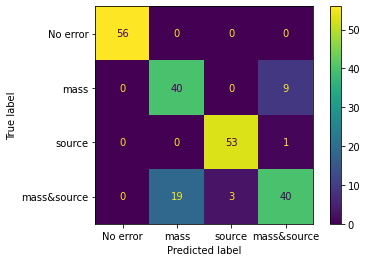

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(final_pred['label'], final_pred['RandomForest'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No error', 'mass', 'source', 'mass&source'])
disp.plot()
plt.savefig("figures/blending/confusion_matrixRandomForest.png")

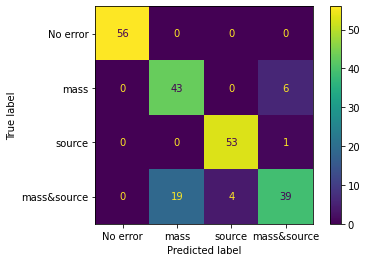

In [26]:
cm = confusion_matrix(final_pred['label'], final_pred['GaussianNB'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No error', 'mass', 'source', 'mass&source'])
disp.plot()
plt.savefig("figures/blending/confusion_matrixGaussianNB.png")

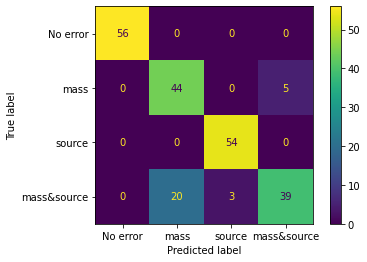

In [27]:
cm = confusion_matrix(final_pred['label'], final_pred['Ridge'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No error', 'mass', 'source', 'mass&source'])
disp.plot()
plt.savefig("figures/blending/confusion_matrixRidge.png")

## 4. Misclassified residual maps

In this section we focus on the residual maps that are classified as mass errors instead of mass and source error. Some of the maps are misclassified in all classifiers.

In [28]:
indx_RF = []
for indx, label_i, class_i in zip(final_pred.index.to_numpy(), final_pred['label'].to_numpy(), final_pred['RandomForest'].to_numpy()):
    if label_i == 3 and class_i == 1:
        indx_RF.append(indx)

indx_NB = []
for indx, label_i, class_i in zip(final_pred.index.to_numpy(), final_pred['label'].to_numpy(), final_pred['GaussianNB'].to_numpy()):
    if label_i == 3 and class_i == 1:
        indx_NB.append(indx)


indx_ridge = []
for indx, label_i, class_i in zip(final_pred.index.to_numpy(), final_pred['label'].to_numpy(), final_pred['Ridge'].to_numpy()):
    if label_i == 3 and class_i == 1:
        indx_ridge.append(indx)

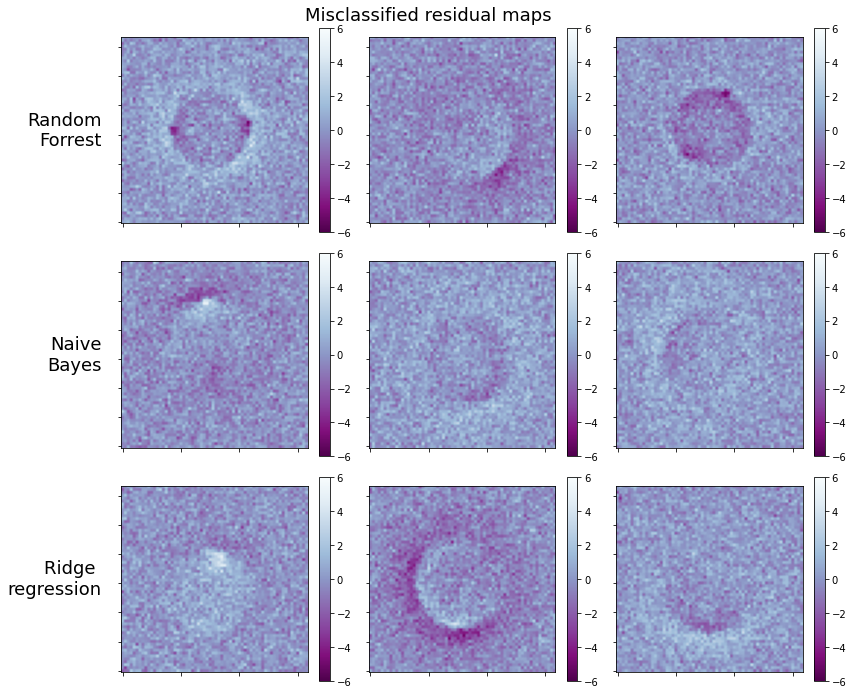

In [30]:
f, axes = plt.subplots(3,3, figsize=(12,10), sharex=False, sharey=False)

for i in range(0,3):
    
    pos1 = axes[0,i].imshow(data_test[indx_RF[i]][0][0], vmin = -6, vmax = 6, origin = 'lower', cmap = plt.cm.BuPu_r)
    pos2 = axes[1,i].imshow(data_test[indx_NB[i+3]][0][0], vmin = -6, vmax = 6, origin = 'lower', cmap = plt.cm.BuPu_r)
    pos3 = axes[2,i].imshow(data_test[indx_ridge[i+6]][0][0], vmin = -6, vmax = 6, origin = 'lower', cmap = plt.cm.BuPu_r)        
    axes[0,i].set_yticklabels([]); axes[0,i].set_xticklabels([])
    axes[1,i].set_yticklabels([]); axes[1,i].set_xticklabels([])
    axes[2,i].set_yticklabels([]); axes[2,i].set_xticklabels([])
    f.colorbar(pos1, ax=axes[0,i]); f.colorbar(pos2, ax=axes[1,i])
    f.colorbar(pos3, ax=axes[2,i])
    
    
pad = 5
font = 18

axes[0,0].annotate('Random\nForrest', xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad - pad, 0),
                    xycoords=axes[0,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
axes[1,0].annotate('Naive\nBayes', xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad - pad, 0),
                    xycoords=axes[1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
axes[2,0].annotate('Ridge \nregression', xy=(0, 0.5), xytext=(-axes[2,0].yaxis.labelpad - pad, 0),
                    xycoords=axes[2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
f.suptitle('Misclassified residual maps', size = 'large',fontsize=font)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

plt.show()
f.savefig('figures/blending/unclassified.png')